In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import constants
from tqdm import tqdm
import numba
import time

In [18]:
# Introduction to NUMBA

In [19]:
## What is NUMBA? 

In [20]:
#NUMBA is a just-in-time compiler (JIT) to translate code written in Python into **optimized** machine code!
#It replaces thereby the slower Python interpreter to modify and compile your code. An huge advantage of NUMBA is its
#compatibility with for-loops *and* with numpy functions! Our trade-off between manual code modifications and performance
#gain should be therefore minimal.

In [64]:
## Speed up!

In [21]:
def example(pos):
    
    N = len(pos)
    distances = np.zeros(N)
    
    i = 0
    
    for r1 in pos:
        for r2 in pos:
            
            distances[i] = np.sqrt(np.sum((r1-r2)**2))
            
    return 'Success'

In [24]:
@numba.jit(nopython = True, fastmath = True)
def example_with_numba(pos):
    
    N = len(pos)
    distances = np.zeros(N)
    
    i = 0
    
    for r1 in pos:
        for r2 in pos:
            
            distances[i] = np.sqrt(np.sum((r1-r2)**2))
            
    return 'Success'

In [27]:
POS = np.random.randn(200, 3)

In [28]:
%timeit example(POS)

1.37 s ± 3.39 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [29]:
%timeit example_with_numba(POS)

5.27 ms ± 27.8 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [65]:
#Caveat 1 - First compilation!

In [41]:
try: del example_with_numba_caveat
except: pass

@numba.jit(nopython = True, fastmath = True)
def example_with_numba_caveat(pos):
    
    N = len(pos)
    distances = np.zeros(N)
    
    i = 0
    
    for r1 in pos:
        for r2 in pos:
            
            distances[i] = np.sqrt(np.sum((r1-r2)**2))
            
    return 'Success'

POS = np.random.randn(200, 3)
start_time = time.time()
example_with_numba_caveat(POS)
print('First compilation:', time.time() - start_time)
start_time = time.time()
example_with_numba_caveat(POS)
print('Second compilation:', time.time() - start_time)

First compilation: 0.6662006378173828
Second compilation: 0.0067098140716552734


In [66]:
#Caveat 2 - Cryptic Errors!

In [67]:
@numba.jit(nopython = True, fastmath = True)
def example_with_numba_caveat_2(pos):
    
    Mean = np.mean(pos, axis = 0)
            
    return Mean

In [68]:
POS = np.random.randn(200, 3)
example_with_numba_caveat_2(POS)

TypingError: Failed in nopython mode pipeline (step: nopython frontend)
No implementation of function Function(<function mean at 0x7f298e8ea820>) found for signature:
 
 >>> mean(array(float64, 2d, C), axis=Literal[int](0))
 
There are 2 candidate implementations:
    - Of which 2 did not match due to:
    Overload in function 'Numpy_method_redirection.generic': File: numba/core/typing/npydecl.py: Line 348.
      With argument(s): '(array(float64, 2d, C), axis=Literal[int](0))':
     Rejected as the implementation raised a specific error:
       TypingError: numba doesn't support kwarg for mean
  raised from /home/marius/miniconda3/envs/Work/lib/python3.8/site-packages/numba/core/typing/npydecl.py:370

During: resolving callee type: Function(<function mean at 0x7f298e8ea820>)
During: typing of call at <ipython-input-67-7c0cca029ba5> (4)


File "<ipython-input-67-7c0cca029ba5>", line 4:
def example_with_numba_caveat_2(pos):
    <source elided>
    
    Mean = np.mean(pos, axis = 0)
    ^


In [69]:
# MD - Code

In [2]:
def init_pos(N, Grid, L):
    
    xmin = ymin = zmin = Grid
    xmax = ymax = zmax = L
    
    X, Y, Z = np.mgrid[xmin:xmax:Grid, ymin:ymax:Grid, zmin:zmax:Grid]
    positions = np.vstack([X.ravel(), Y.ravel(), Z.ravel()])
    init = np.random.choice(len(positions.T), replace = False, size = N)
    
    return positions.T[init]

def init_vel(N, SD, DIS):
    
    if DIS == 'normal':
        assert SD > 0, 'STD should be > 0'
        
        return np.random.normal(size = (N, 3), loc = 0, scale = SD)
    
    if DIS == 'uniform':
        
        return np.random.uniform(size = (N, 3))
    
def init(N, Grid, L, SD, DIS):
    
    return init_pos(N, Grid, L), init_vel(N, SD, DIS)

In [3]:
def write_file(FILE1, FILE2, FILE3, FILE4, coords, vels, PE, KE, n_iter):


    #Coordinates are round to the second decimal position to faciliate saving
    round_ = 2

    #Write head for each frame12     
    FILE1.write('Model {}\n'.format(n_iter)) #Start of a frame
    FILE2.write('Model {}\n'.format(n_iter)) #Start of a frame
    N = coords.shape[0]

    #Just iterate over all coordinates and write them down line per line
    for i in range(N):

        #The PDB-formate is really strict the line below is from: https://cupnet.net/pdb-format/

        #ATOM  #ID   #NAME     #RESN      #RESID          #X    #Y     #Z
        coord_str = "{:6s}{:5d} {:^4s}{:1s}{:3s} {:1s}{:4d}{:1s}   {:8.3f}{:8.3f}{:8.3f}{:6.2f}{:6.2f}          {:>2s}{:2s}\n".format('ATOM', int(i),
                                                                                                                         'PAR', ' ', 'ARG',
                                                                                                                         ' ', int(i), ' ',
                                                                                                                         np.round(coords[i][0], round_)*10,
                                                                                                                         np.round(coords[i][1], round_)*10,
                                                                                                                         np.round(coords[i][2], round_)*10,
                                                                                                                          1.0, 1.0, 'ARG', ' ')


        FILE1.write(coord_str) #Write coordinates
        FILE2.write('{}\t\t{}\t\t{}\n'.format(vels[i][0], vels[i][1], vels[i][2])) #Write velocities
    FILE1.write('TER\nENDMDL\n') #End of a frame

    #Write down Temperature, Pressure and Volume
    FILE3.write('{};{}\n'.format(n_iter, PE))
    FILE4.write('{};{}\n'.format(n_iter, KE))
                                                

In [4]:
@numba.jit(nopython = True, fastmath = True)
def pbc_dist(r_ij, L):
    
    dist_vec = np.zeros(3)
    
    for i in range(3):
        
        abs_liste = np.array([r_ij[i], r_ij[i] + L, r_ij[i] - L])
        argmin_abs = np.argmin(np.abs(abs_liste))
        
        dist_vec[i] = abs_liste[argmin_abs]
        
    dist = np.linalg.norm(dist_vec)
        
    return dist, dist_vec

In [5]:
@numba.jit(nopython = True, fastmath = True)
def pair_list(r, N, rc, L):
    
    pair_list_x = []
    pair_list_y = []
    
    for i in range(0, N):
        for j in range(i+1, N):
            
            diff_ij = r[i] - r[j]
            
            dr_ij, r_ij = pbc_dist(diff_ij, L)
            
            if dr_ij <= rc: 
                pair_list_x.append(i)
                pair_list_y.append(j)
                
            else: pass
    
    return np.array([pair_list_x, pair_list_y], dtype = np.int32)

In [7]:
N = 1000
r = np.random.uniform(-1, 11, (N, 3))
rc = 1000
L = 10

In [ ]:
%timeit pair_list(r, N, rc, L) #No Numba -> 1000 Particles -> 48.9 s

In [11]:
%timeit pair_list(r, N, rc, L) #With Numba -> 1000 Particles -> 819ms

819 ms ± 6.04 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [8]:
%timeit pair_list(r, N, rc, L) #With Numba and Fastmath -> 1000 Particles -> 827 ms

827 ms ± 17.8 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [8]:
N = 1000
r = np.random.uniform(-1, 11, (N, 3)) * np.random.randn(N, 3) + 10
rc = 1000
L = 10
pl = pair_list(r, N, rc, L)

In [63]:
%timeit force(r, N, 1, 0.34, pl, L) #No Numba -> 1000 Particles -> 18.5s

18.5 s ± 28.2 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [53]:
%timeit force(r, N, 1, 0.34, pl, L) #Numba -> 1000 Particles -> 191ms

191 ms ± 2.78 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [6]:
@numba.jit(nopython = True, fastmath = True)
def kinetic(v, m):
    
    return 0.5 * m * np.sum(v**2)

In [11]:
v = np.random.randn(N, 3)
m = 39.948

In [70]:
%timeit kinetic(v, m) #No Numba -> 1000 Particles -> 

33.6 µs ± 888 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [76]:
%timeit kinetic(v, m) #No Numba -> 1000 Particles -> 

12.1 µs ± 57 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)


In [7]:
#@numba.jit(nopython = True, fastmath = True)
#def pbc(r, v, L):
#    r %= L
#    v -= np.mean(a = v, axis = 0)   
#    return r, v

@numba.jit(nopython = True, fastmath = True)
def pbc(r, v, L):
    
    r %= L
    
    mean = np.zeros(3)
    counter = 0
    for vec in v:
        mean += vec
        counter +=1
    mean /= counter
    v -= mean #np.mean(a = v, axis = 0)
    
    return r, v

In [8]:
@numba.jit(nopython = True, fastmath = True)
def pressure(N, V, T, dV):
    
    NA = 6.02214086
    
    S1 = N * constants.R * 1E-3 * T
    
    S2 = 1.0/3.0 * 1.0/2.0 * dV
    
    return ((S1 - S2) / V) * (1E+2 / NA)


@numba.jit(nopython = True, fastmath = True)
def force(rdt, N, sig, eps, pair_mask, L, rc, T):
    
    f = np.zeros((N, 3))
    
    Vol = L * L * L
    
    dV_sum = 0
    
    pote = 0
    
    for pair in pair_mask.T:
        
        i, j = pair
            
        diff_ij = rdt[i] - rdt[j]
            
        dr_ij, r_ij = pbc_dist(diff_ij, L)
        
        if dr_ij <= rc:
            
            dV = 48. * eps * ((sig**12)*(dr_ij**-13) - 0.5 *  (sig**6)*(dr_ij**-7))
        
            f_ij = dV / dr_ij * r_ij

            f[i] += f_ij
            f[j] -= f_ij
        
            pote += 4. * eps * ((sig/dr_ij)**12 - (sig/dr_ij)**6)
            
            dV_sum += dV
            
    p = pressure(N, Vol, T, dV_sum)
    
    return f, pote, p

@numba.jit(nopython = True, fastmath = True)
def velocity_verlet(r, v, f, m, eps, sig, dt, boundary, N, L, pair_list_update, rc, rb, step, pair_mask, T):
    
    rdt = r + dt * v + f * dt**2 / 2 / m

    rdt, v = boundary(rdt, v, L)
    
    if not step % pair_list_update: pair_mask = pair_list(rdt, N, rb, L)
    
    fdt, pote, press = force(rdt, N, sig, eps, pair_mask, L, rc, T) 
    
    vdt = v + dt * (f + fdt) / 2 / m
    
    return rdt, vdt, fdt, pote, pair_mask, press
    
    

In [13]:
@numba.jit(nopython = True, fastmath = True)
def ideal_volume(T, N, P):
    
    return ((T * N * 1.38 * 1E-23) / (P * 1E+5 * 1E-27))**(1./3.)

In [9]:
@numba.jit(nopython = True, fastmath = True)
def temperature(v, m, N):
    
    return (m * 1E+3 * np.sum(v**2)) / (3 * N * constants.R)

@numba.jit(nopython = True, fastmath = True)
def berendsen_thermostat(T0, T, dt, tau, v):
    
    v *= np.sqrt(1 + (dt/tau) * (T0/T - 1))
    
    return v

@numba.jit(nopython = True, fastmath = True)
def berendsen_barostat(P0, P, dt, beta, tau, L, r):
    
    mu = (1 + dt * beta * (P - P0) / tau)**(1./3.)
    
    L *= mu
    r *= mu
    
    return L, r

In [20]:
def main(n_steps, N, L, dt, static, TEMPS, TEMP0, PRESS0, init_random, boundary, update, pair_list_update, rc, rb, tauT, tauP, file1, file2, file3, file4, r_init = 0, v_init = 0, distri = 'normal'):
    
    m = 39.948 #a.m.u.
    sig = 0.34
    eps = 1.0
    beta = 1.8*10**(-4)
    
    f1, f2, f3, f4 = open(file1, 'w'), open(file2, 'w'), open(file3, 'w'), open(file4, 'w')
    
    s = str('CRYST1'+ str("{:9.3f}{:9.3f}{:9.3f}".format(L*10,L*10,L*10)) + "  90.00  90.00  90.00 P 1           1\n")
    f1.write(s)
    
    if init_random: 
        sd = np.sqrt(constants.R * 0.001 * TEMPS / m)
        r, v = init(N, 0.5, L, sd, distri)
        
        if boundary == pbc: v -= np.mean(v, axis = 0)
        
    else:
        r = r_init
        v = v_init
        
    kin_ener = np.zeros(int(n_steps / update))
    pot_ener = np.zeros(int(n_steps / update))
    temp = np.zeros(int(n_steps / update))
    pressure = np.zeros(int(n_steps / update))
    vel_store = np.zeros((int(n_steps / update), N, 3))
    
    T = temperature(v, m, N)
    pair_mask = pair_list(r, N, rb, L)
    f, pote, press = force(r, N, sig, eps, pair_mask, L, rc, T)
    
    
    kine = kinetic(v, m)
    
    kin_ener[0] = kine
    pot_ener[0] = pote
    vel_store[0] = v
    temp[0] = T
    pressure[0] = press
    
    write_file(f1, f2, f3, f4, r, v, pote, kine, 0)
        
    c = 1
    
    for step in tqdm(range(1, n_steps)):
        
        r, v, f, pote, pair_mask, press = velocity_verlet(r, v, f, m, eps, sig, dt, boundary, N, L,
                                                          pair_list_update, rc, rb, step, pair_mask, T)
        
        if static:
            v = berendsen_thermostat(T0 = TEMP0, T = T, dt = dt, tau = tauT, v = v)
            L, r = berendsen_barostat(P0 = PRESS0, P = press, dt = dt, beta = beta, tau = tauP, L = L, r = r)
        
        T = temperature(v, m, N)
        
        if not step % update: 
           # write_file(f1, f2, f3, f4, r, v, pote, kine, 0)
            
            kine = kinetic(v, m)
            
            kin_ener[c] = kine
            pot_ener[c] = pote
            vel_store[c] = v
            temp[c] = T
            pressure[c] = press
            c+=1
            
    return kin_ener, pot_ener, vel_store, temp, pressure

In [14]:
ideal_volume(T = 300, N = 200, P = 1)

20.230662838988824

In [21]:
KINE, POTE, VEL, TEMP, PRESS = main(n_steps = 50000, N = 200, L = 20, dt = 1E-3, TEMPS = 300, TEMP0 = 300, PRESS0 = 1, init_random = 1, boundary = pbc, update = 100, pair_list_update = 10, rc = 1., rb = 1.5, 
                                    tauT = 1.0, tauP = 1.0, static = True, file1 = 'Test.pdb', file2 = 'Vel.txt', file3 = 'POTE.txt', file4 = 'KINE.txt')

100%|██████████| 49999/49999 [02:37<00:00, 317.50it/s]


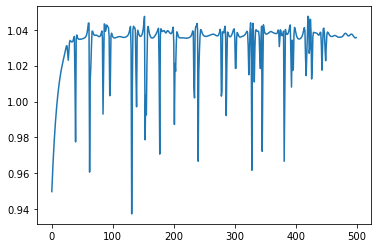

In [22]:
plt.plot(PRESS)

# Energy of two particles - Only potential energy

In [19]:
r_init = np.array([[5, 5, 4], [5, 5, 5]])
v_init = np.zeros((2, 3))

In [27]:
KINE, POTE, VEL = main(n_steps = 1000, N = 2, L = 10, dt = 1E-1, TEMPS = 100, init_random = 0, boundary = pbc, update = 1,
                  pair_list_update = 1, rc = 1000., rb = 1000., file1 = 'Test.pdb', file2 = 'Vel.txt', file3 = 'POTE.txt', file4 = 'KINE.txt',
                  r_init = r_init, v_init = v_init)

100%|██████████| 999/999 [00:00<00:00, 13361.49it/s]


In [148]:
np.save(arr = KINE, file='KINE_VERY_SHORT')
np.save(arr = POTE, file='POTE_VERY_SHORT')

In [11]:
KINE_BIGGER_TIMESTEP = np.load('KINE_VERY_SHORT.npy')
POTE_BIGGER_TIMESTEP = np.load('POTE_VERY_SHORT.npy')

In [135]:
KINE, POTE, VEL = main(n_steps = 100000, N = 2, L = 10, dt = 1E-3, TEMPS = 100, init_random = 0, boundary = pbc, update = 1,
                  pair_list_update = 1, rc = 1000., file1 = 'Test.pdb', file2 = 'Vel.txt', file3 = 'POTE.txt', file4 = 'KINE.txt',
                  r_init = r_init, v_init = v_init)

100%|██████████| 99999/99999 [00:45<00:00, 2189.68it/s]


In [136]:
np.save(arr = KINE, file='KINE_SHORT')
np.save(arr = POTE, file='POTE_SHORT')

In [12]:
KINE_BIG_TIMESTEP = np.load('KINE_SHORT.npy')
POTE_BIG_TIMESTEP = np.load('POTE_SHORT.npy')

In [140]:
KINE, POTE, VEL = main(n_steps = 10000000, N = 2, L = 10, dt = 1E-5, TEMPS = 100, init_random = 0, boundary = pbc, update = 1,
                  pair_list_update = 1, rc = 1000., file1 = 'Test.pdb', file2 = 'Vel.txt', file3 = 'POTE.txt', file4 = 'KINE.txt',
                  r_init = r_init, v_init = v_init) #With Numba: 11 min instead of 50

100%|██████████| 9999999/9999999 [11:47<00:00, 14137.71it/s]


In [122]:
10000000*1E-5

100.00000000000001

In [142]:
np.save(arr = KINE, file='KINE_LONG')
np.save(arr = POTE, file='POTE_LONG')

In [13]:
KINE_SMALL_TIMESTEP = np.load('KINE_LONG.npy')
POTE_SMALL_TIMESTEP = np.load('POTE_LONG.npy')

In [49]:
t0 = np.linspace(0, 100, 1000)
t1 = np.linspace(0, 100, 100000)
t2 = np.linspace(0, 100, 10000000)

(15.0, 25.0)

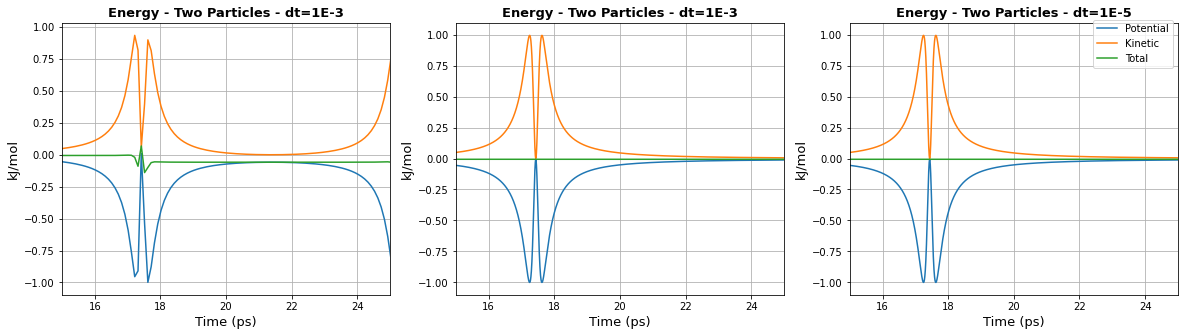

In [20]:


fig, ax = plt.subplots(1, 3, figsize = (20, 5))

ax[0].plot(t0, POTE_BIGGER_TIMESTEP, label = 'Potential')
ax[0].plot(t0, KINE_BIGGER_TIMESTEP, label = 'Kinetic')
ax[0].plot(t0, KINE_BIGGER_TIMESTEP + POTE_BIGGER_TIMESTEP, label = 'Total')
ax[0].grid(True)
ax[0].set_title('Energy - Two Particles - dt=1E-3', fontweight = 'bold', fontsize = 13)
ax[0].set_ylabel('kJ/mol', fontsize = 13)
ax[0].set_xlabel('Time (ps)', fontsize = 13)

ax[1].plot(t1, POTE_BIG_TIMESTEP, label = 'Potential')
ax[1].plot(t1, KINE_BIG_TIMESTEP, label = 'Kinetic')
ax[1].plot(t1, KINE_BIG_TIMESTEP + POTE_BIG_TIMESTEP, label = 'Total')
ax[1].grid(True)
ax[1].set_title('Energy - Two Particles - dt=1E-3', fontweight = 'bold', fontsize = 13)
ax[1].set_ylabel('kJ/mol', fontsize = 13)
ax[1].set_xlabel('Time (ps)', fontsize = 13)
#ax[0].legend(bbox_to_anchor=(1., 1.03))

ax[2].plot(t2, POTE_SMALL_TIMESTEP, label = 'Potential')
ax[2].plot(t2, KINE_SMALL_TIMESTEP, label = 'Kinetic')
ax[2].plot(t2, KINE_SMALL_TIMESTEP + POTE_SMALL_TIMESTEP, label = 'Total')
ax[2].grid(True)
ax[2].set_title('Energy - Two Particles - dt=1E-5', fontweight = 'bold', fontsize = 13)
ax[2].set_ylabel('kJ/mol', fontsize = 13)
ax[2].set_xlabel('Time (ps)', fontsize = 13)
ax[2].legend(bbox_to_anchor=(1., 1.03))
#plt.savefig('Energy_Two_Particles.png', dpi = 300)

ax[0].set_xlim(15, 25)
ax[1].set_xlim(15, 25)
ax[2].set_xlim(15, 25)

/home/marius/miniconda3/envs/Work/lib/python3.8/site-packages/IPython/core/pylabtools.py:132: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


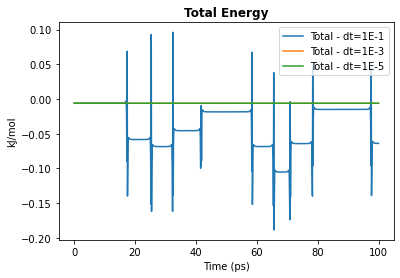

In [16]:
plt.plot(t0, KINE_BIGGER_TIMESTEP + POTE_BIGGER_TIMESTEP, label = 'Total - dt=1E-1')
plt.plot(t1, KINE_BIG_TIMESTEP + POTE_BIG_TIMESTEP, label = 'Total - dt=1E-3')
plt.plot(t2, KINE_SMALL_TIMESTEP + POTE_SMALL_TIMESTEP, label = 'Total - dt=1E-5')
plt.ylabel('kJ/mol')
plt.xlabel('Time (ps)')
plt.title('Total Energy', fontweight = 'bold')
plt.legend()

/home/marius/miniconda3/envs/Work/lib/python3.8/site-packages/IPython/core/pylabtools.py:132: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


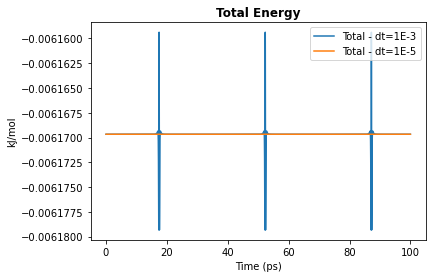

In [50]:

plt.plot(t1, KINE_BIG_TIMESTEP + POTE_BIG_TIMESTEP, label = 'Total - dt=1E-3')
plt.plot(t2, KINE_SMALL_TIMESTEP + POTE_SMALL_TIMESTEP, label = 'Total - dt=1E-5')
plt.ylabel('kJ/mol')
plt.xlabel('Time (ps)')
plt.title('Total Energy', fontweight = 'bold')
plt.legend()

# With and without Pair-List

In [17]:
#Start from the same configuration each time
sd = np.sqrt(constants.R * 0.001 * 10 / 39.948)
r_init, v_init = pymd.init(10, 0.5, 5, sd, 'normal')
v_init -= np.mean(v_init , 0)

In [57]:
KINE_1_WO_CO, POTE_1_WO_CO, VEL_1_WO_CO = main(n_steps = 50000, N = 10, L = 5, dt = 1E-3, TEMPS = 100, init_random = 0, boundary = pbc, update = 100,
                                  pair_list_update = 1, rc = 1000., rb = 1000,
                                               file1 = 'Test.pdb', file2 = 'Vel.txt', file3 = 'POTE.txt', file4 = 'KINE.txt',
                                  r_init = r_init, v_init = v_init)

100%|██████████| 49999/49999 [00:13<00:00, 3754.81it/s]


In [58]:
np.save(arr = KINE_1_WO_CO, file = 'TESTING_MD/KINE_1_WO_CO')
np.save(arr = POTE_1_WO_CO, file = 'TESTING_MD/POTE_1_WO_CO')
KINE_1_WO_CO = np.load('TESTING_MD/KINE_1_WO_CO.npy')
POTE_1_WO_CO = np.load('TESTING_MD/POTE_1_WO_CO.npy')

In [59]:
KINE_1, POTE_1, VEL_1 = main(n_steps = 50000, N = 10, L = 5, dt = 1E-3, TEMPS = 100, init_random = 0, boundary = pbc, update = 100,
                      pair_list_update = 1, rc = 1., rb = 1.5, file1 = 'Test.pdb', file2 = 'Vel.txt', file3 = 'POTE.txt', file4 = 'KINE.txt',
                      r_init = r_init, v_init = v_init)

100%|██████████| 49999/49999 [00:09<00:00, 5399.91it/s]


In [60]:
np.save(arr = KINE_1, file = 'TESTING_MD/KINE_1')
np.save(arr = POTE_1, file = 'TESTING_MD/POTE_1')
KINE_1 = np.load('TESTING_MD/KINE_1.npy')
POTE_1 = np.load('TESTING_MD/POTE_1.npy')

In [62]:
KINE_10, POTE_10, VEL_10 = main(n_steps = 50000, N = 10, L = 5, dt = 1E-3, TEMPS = 100, init_random = 0, boundary = pbc, update = 100,
                        pair_list_update = 10, rc = 1., rb = 1.5, file1 = 'Test.pdb', file2 = 'Vel.txt', file3 = 'POTE.txt', file4 = 'KINE.txt',
                        r_init = r_init, v_init = v_init)

100%|██████████| 49999/49999 [00:03<00:00, 13208.92it/s]


In [63]:
np.save(arr = KINE_10, file = 'TESTING_MD/KINE_10')
np.save(arr = POTE_10, file = 'TESTING_MD/POTE_10')
KINE_10 = np.load('TESTING_MD/KINE_10.npy')
POTE_10 = np.load('TESTING_MD/POTE_10.npy')

In [64]:
KINE_20, POTE_20, VEL_20 = main(n_steps = 50000, N = 10, L = 5, dt = 1E-3, TEMPS = 100, init_random = 0, boundary = pbc, update = 100,
                        pair_list_update = 20, rc = 1., rb = 1.5, file1 = 'Test.pdb', file2 = 'Vel.txt', file3 = 'POTE.txt', file4 = 'KINE.txt',
                        r_init = r_init, v_init = v_init)

100%|██████████| 49999/49999 [00:03<00:00, 13971.57it/s]


In [65]:
np.save(arr = KINE_20, file = 'TESTING_MD/KINE_20')
np.save(arr = POTE_20, file = 'TESTING_MD/POTE_20')
KINE_20 = np.load('TESTING_MD/KINE_20.npy')
POTE_20 = np.load('TESTING_MD/POTE_20.npy')

In [66]:
KINE_30, POTE_30, VEL_10 = main(n_steps = 50000, N = 10, L = 5, dt = 1E-3, TEMPS = 100, init_random = 0, boundary = pbc, update = 100,
                        pair_list_update = 30, rc = 1., rb = 1.5, file1 = 'Test.pdb', file2 = 'Vel.txt', file3 = 'POTE.txt', file4 = 'KINE.txt',
                        r_init = r_init, v_init = v_init)

100%|██████████| 49999/49999 [00:03<00:00, 14320.42it/s]


In [67]:
np.save(arr = KINE_30, file = 'TESTING_MD/KINE_30')
np.save(arr = POTE_30, file = 'TESTING_MD/POTE_30')
KINE_30 = np.load('TESTING_MD/KINE_30.npy')
POTE_30 = np.load('TESTING_MD/POTE_30.npy')

In [68]:
KINE_50, POTE_50, VEL_50 = main(n_steps = 50000, N = 10, L = 5, dt = 1E-3, TEMPS = 100, init_random = 0, boundary = pbc, update = 100,
                        pair_list_update = 50, rc = 1., rb = 1.5, file1 = 'Test.pdb', file2 = 'Vel.txt', file3 = 'POTE.txt', file4 = 'KINE.txt',
                        r_init = r_init, v_init = v_init)

100%|██████████| 49999/49999 [00:03<00:00, 14593.27it/s]


In [69]:
np.save(arr = KINE_50, file = 'TESTING_MD/KINE_50')
np.save(arr = POTE_50, file = 'TESTING_MD/POTE_50')
KINE_50 = np.load('TESTING_MD/KINE_50.npy')
POTE_50 = np.load('TESTING_MD/POTE_50.npy')

In [70]:
KINE_50.shape

(500,)

Without Pair_List and without Cut-Off = 50:44

Without Pair_List = 27:19

With Pair_List 10 = 08:17

With Pair_List 20 = 06:54

With Pair_List 30 = 06:17

With Pair_List 50 = 05:09

In [71]:
t = np.linspace(0, 50, 500)
t1 = np.linspace(0, 50, 50000)

Text(0.5, 0, 'Time (ps)')

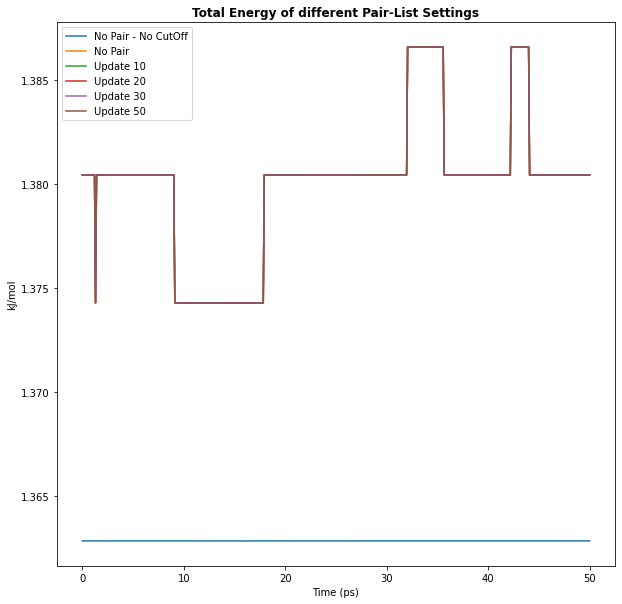

In [72]:
fig = plt.figure(figsize = (10, 10))
plt.plot(t, KINE_1_WO_CO[:] + POTE_1_WO_CO[:], label = 'No Pair - No CutOff')
plt.plot(t, KINE_1[:] + POTE_1[:], label = 'No Pair')
plt.plot(t, KINE_10[:] + POTE_10[:], label = 'Update 10')
plt.plot(t, KINE_20[:] + POTE_20[:], label = 'Update 20')
plt.plot(t, KINE_30[:] + POTE_30[:], label = 'Update 30')
plt.plot(t, KINE_50[:] + POTE_50[:], label = 'Update 50')

#plt.ylim([1.4, 1.45])
plt.title('Total Energy of different Pair-List Settings', fontweight = 'bold')
plt.legend()
plt.ylabel('kJ/mol')
plt.xlabel('Time (ps)')

# Scaling

In [113]:
def get_vol(p, n):
    
    return (n/p)**(1/3)

2.0

In [108]:
KINE_Scaling10, POTE_Scaling10 = main(n_steps = 100, N = 10, L = 2, dt = 1E-3, TEMPS = 100, init_random = 1, boundary = pbc, update = 100,
                                      pair_list_update = 10, rc = 1., file1 = 'Test.pdb', file2 = 'Vel.txt', file3 = 'POTE.txt', file4 = 'KINE.txt',
                                      r_init = r_init, v_init = v_init)

100%|██████████| 99/99 [00:00<00:00, 381.92it/s]


In [116]:
KINE_Scaling10, POTE_Scaling10 = main(n_steps = 100, N = 100, L = 4.3, dt = 1E-3, TEMPS = 100, init_random = 1, boundary = pbc, update = 100,
                                      pair_list_update = 10, rc = 1., file1 = 'Test.pdb', file2 = 'Vel.txt', file3 = 'POTE.txt', file4 = 'KINE.txt',
                                      r_init = r_init, v_init = v_init)

100%|██████████| 99/99 [00:02<00:00, 33.29it/s]


In [118]:
KINE_Scaling10, POTE_Scaling10 = main(n_steps = 100, N = 300, L = 6.21, dt = 1E-3, TEMPS = 100, init_random = 1, boundary = pbc, update = 100,
                                      pair_list_update = 10, rc = 1., file1 = 'Test.pdb', file2 = 'Vel.txt', file3 = 'POTE.txt', file4 = 'KINE.txt',
                                      r_init = r_init, v_init = v_init)

100%|██████████| 99/99 [00:15<00:00,  6.26it/s]


In [120]:
KINE_Scaling10, POTE_Scaling10 = main(n_steps = 100, N = 500, L = 7.37, dt = 1E-3, TEMPS = 100, init_random = 1, boundary = pbc, update = 100,
                                      pair_list_update = 10, rc = 1., file1 = 'Test.pdb', file2 = 'Vel.txt', file3 = 'POTE.txt', file4 = 'KINE.txt',
                                      r_init = r_init, v_init = v_init)

100%|██████████| 99/99 [00:38<00:00,  2.60it/s]


In [121]:
get_vol(1.25, 700)

8.242570599617112

In [122]:
KINE_Scaling10, POTE_Scaling10 = main(n_steps = 100, N = 700, L = 8.24, dt = 1E-3, TEMPS = 100, init_random = 1, boundary = pbc, update = 100,
                                      pair_list_update = 10, rc = 1., file1 = 'Test.pdb', file2 = 'Vel.txt', file3 = 'POTE.txt', file4 = 'KINE.txt',
                                      r_init = r_init, v_init = v_init)

100%|██████████| 99/99 [01:12<00:00,  1.36it/s]


In [123]:
KINE_Scaling10, POTE_Scaling10 = main(n_steps = 100, N = 10, L = 2, dt = 1E-3, TEMPS = 100, init_random = 1, boundary = pbc, update = 100,
                                      pair_list_update = 1, rc = 1000., file1 = 'Test.pdb', file2 = 'Vel.txt', file3 = 'POTE.txt', file4 = 'KINE.txt',
                                      r_init = r_init, v_init = v_init)

100%|██████████| 99/99 [00:00<00:00, 158.37it/s]


In [124]:
KINE_Scaling10, POTE_Scaling10 = main(n_steps = 100, N = 100, L = 4.3, dt = 1E-3, TEMPS = 100, init_random = 1, boundary = pbc, update = 100,
                                      pair_list_update = 1, rc = 1000., file1 = 'Test.pdb', file2 = 'Vel.txt', file3 = 'POTE.txt', file4 = 'KINE.txt',
                                      r_init = r_init, v_init = v_init)

100%|██████████| 99/99 [01:00<00:00,  1.63it/s]


In [ ]:
26*60 +55

In [ ]:
KINE_Scaling10, POTE_Scaling10 = main(n_steps = 100, N = 300, L = 6.21, dt = 1E-3, TEMPS = 100, init_random = 1, boundary = pbc, update = 100,
                                      pair_list_update = 1, rc = 1000., file1 = 'Test.pdb', file2 = 'Vel.txt', file3 = 'POTE.txt', file4 = 'KINE.txt',
                                      r_init = r_init, v_init = v_init)

In [128]:
KINE_Scaling10, POTE_Scaling10 = main(n_steps = 100, N = 500, L = 7.37, dt = 1E-3, TEMPS = 100, init_random = 1, boundary = pbc, update = 100,
                                      pair_list_update = 1, rc = 1000., file1 = 'Test.pdb', file2 = 'Vel.txt', file3 = 'POTE.txt', file4 = 'KINE.txt',
                                      r_init = r_init, v_init = v_init)

  2%|▏         | 2/99 [02:45<2:13:29, 82.57s/it]


KeyboardInterrupt: 

In [129]:
KINE_Scaling10, POTE_Scaling10 = main(n_steps = 100, N = 700, L = 8.24, dt = 1E-3, TEMPS = 100, init_random = 1, boundary = pbc, update = 100,
                                      pair_list_update = 1, rc = 1000., file1 = 'Test.pdb', file2 = 'Vel.txt', file3 = 'POTE.txt', file4 = 'KINE.txt',
                                      r_init = r_init, v_init = v_init)

  1%|          | 1/99 [03:27<5:39:11, 207.66s/it]


KeyboardInterrupt: 

In [131]:
2*60*60+13*60+29

8009

Text(0, 0.5, 'Time (s)')

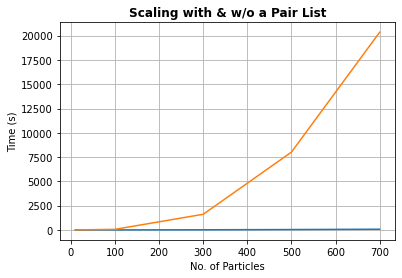

In [134]:
WITH_PAIR = [0, 2, 15, 38, 72]
WO_PAIR = [0, 60, 1610, 8009, 20351]
N = [10, 100, 300, 500, 700]
plt.plot(N, WITH_PAIR, label = 'With Pair-List')
plt.plot(N, WO_PAIR, label = 'Without Pair-List')
plt.grid(True)
plt.title('Scaling with & w/o a Pair List', fontweight = 'bold')
plt.xlabel('No. of Particles')
plt.ylabel('Time (s)')

# Not normal

In [38]:
NN_KINE, NN_POTE, NN_VEL = main(n_steps = 100000, N = 200, L = 10, dt = 1E-3, TEMPS = 300, init_random = 1, boundary = pbc, update = 100,
                  pair_list_update = 10, rc = 1., rb = 1.5, file1 = 'Test_NN.pdb', file2 = 'Vel_NN.txt', file3 = 'POTE.txt', file4 = 'KINE.txt',
                  distri = 'uniform')

  0%|          | 30/99999 [00:00<05:56, 280.74it/s]

[[  0   0   1   1   1   1   1   1   1   1   2   2   2   3   3   4   5   5
    5   5   6   6   6   7   7   8   8   8   9   9   9   9  10  11  12  12
   12  12  13  13  13  13  14  14  14  15  15  15  15  15  15  16  16  16
   16  16  17  18  18  19  19  19  20  20  20  20  20  21  21  21  21  22
   22  23  23  23  23  24  24  24  25  25  25  25  26  26  26  26  27  27
   27  28  29  30  31  31  31  31  32  32  33  33  34  35  35  36  36  37
   38  39  39  39  41  41  41  41  41  42  42  43  45  46  46  47  47  47
   47  49  49  49  49  51  51  52  53  53  54  54  55  55  56  56  56  57
   57  58  59  60  60  61  61  62  63  64  65  65  66  66  67  68  69  69
   69  69  69  70  71  71  72  72  72  72  73  73  74  76  76  76  76  78
   78  78  78  79  79  80  80  80  82  82  83  83  84  85  85  85  86  86
   86  87  90  90  90  93  95  96  96  96  96  99 100 100 100 100 100 101
  101 101 102 102 103 105 105 105 105 106 106 107 107 107 107 108 109 110
  111 111 111 112 112 112 113 113 113 

100%|██████████| 99999/99999 [05:58<00:00, 278.73it/s]


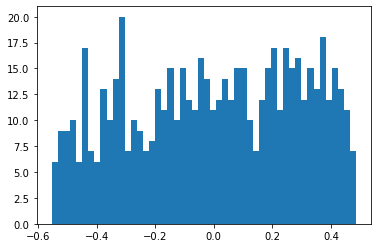

In [42]:
ax = plt.hist(NN_VEL[0].flatten(), bins = 50)

(array([ 1.,  0.,  0.,  0.,  1.,  0.,  1.,  1.,  5.,  2.,  8.,  1.,  8.,
        10., 11., 14., 23., 28., 23., 27., 15., 33., 42., 21., 39., 26.,
        32., 25., 22., 24., 24., 28., 20., 14.,  8., 19., 11.,  8.,  5.,
         5.,  5.,  3.,  2.,  1.,  3.,  0.,  0.,  0.,  0.,  1.]),
 array([-0.96408229, -0.92545248, -0.88682267, -0.84819287, -0.80956306,
        -0.77093325, -0.73230344, -0.69367363, -0.65504383, -0.61641402,
        -0.57778421, -0.5391544 , -0.5005246 , -0.46189479, -0.42326498,
        -0.38463517, -0.34600536, -0.30737556, -0.26874575, -0.23011594,
        -0.19148613, -0.15285632, -0.11422652, -0.07559671, -0.0369669 ,
         0.00166291,  0.04029271,  0.07892252,  0.11755233,  0.15618214,
         0.19481195,  0.23344175,  0.27207156,  0.31070137,  0.34933118,
         0.38796098,  0.42659079,  0.4652206 ,  0.50385041,  0.54248022,
         0.58111002,  0.61973983,  0.65836964,  0.69699945,  0.73562925,
         0.77425906,  0.81288887,  0.85151868,  0.89014849,

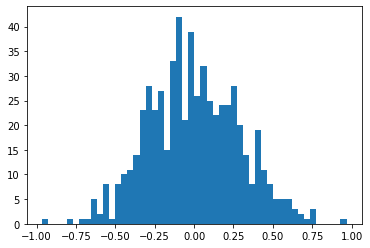

In [41]:
plt.hist(NN_VEL[-1].flatten(), bins = 50)